# **Arquitectura Funcional de V1**

Se muestra la implementación del modelado fibrilar de V1 presentado en el trabajo de fin de grado "*Nuevos modelos de visión basados en Neurogeometría*".
<br><br>

Domingo Paniagua Molina

28/05/2024

## **Precargamos algunas imágenes y cálculos**

Se descargan algunas imágenes de prueba para poder comprobar el funcionamiento del algoritmo. Igualmente se descargan cálculos que hemos guardado haciendo experimentos con las distintas imágenes que se han obtenido con el modelo presente en este notebook. La razón de cargar estos datos es poder ver el funcionamiento del algoritmo sin tener que esperar al cálculo del mismo, que es computacionalmente costoso. Igualmente se puede testear el algoritmo a partir de una imagen.

In [ ]:
#!pip install gdown
!rm -rf img resultados safeCalcs sample_data
!mkdir -p img safeCalcs resultados
!gdown 1mCOAeLTl9LLQ0dulNGIZ0O9mpFA33-Dx -q -O ./img/images.zip
#descomprimo las imágenes
!unzip -q ./img/images.zip -d ./img #modo quiet
!rm -f ./img/images.zip

!gdown 1mXO0OTayqo8N11_S2URIqMvyjXujBv55 -q -O ./safeCalcs/calcs.zip
#descomprimo los cálculos guardados
!unzip -q ./safeCalcs/calcs.zip -d ./safeCalcs #modo quiet
!rm -f ./safeCalcs/calcs.zip

!echo "Cálculos e imágenes cargadas"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import plotly.graph_objects as go
import cv2
from tqdm.notebook import tqdm
import os
%matplotlib inline

Cálculos e imágenes cargadas


## **Filtros de Gabor**

Visualicemos un filtro de gabor definido en $\mathbb{R}^2$: $$$$  $$\begin{aligned} \Psi : \mathbb{R}^2 &\longrightarrow \mathbb{C} \\ \Psi(x,y) &\longmapsto e^{-(x^2+y^2)} e^{2iy} \end{aligned}$$

In [ ]:
def gabor(x,y,x0,y0,theta):
    return np.exp(-((x-x0)**2 + (y-y0)**2)) * np.exp(2j*(- np.sin(theta)*(x-x0) + np.cos(theta)*(y-y0)))

def plot_gabor(x0,y0,theta,plot3d=False):
    cmap = 'viridis'
    levels = 30

    #veamos un ejemplo
    x_gab = np.linspace(-4+x0,4+x0,1000)
    y_gab = np.linspace(-3+y0,3+y0,1000)

    X, Y = np.meshgrid(x_gab, y_gab)
    Z = gabor(X,Y,x0,y0,theta) #el ejemplo anterior

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1,2,1)
    c1 = ax1.contourf(Y, X, Z.real, cmap=cmap,levels=levels)
    ax1.set_title("Parte real del filtro de centro ({},{}) y orient. pref. {:.3f}".format(x0,y0,theta))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylim(-2+y0,2+y0)
    plt.colorbar(c1,ax=ax1)

    ax2 = fig.add_subplot(1,2,2)
    c2 = ax2.contourf(Y, X, Z.imag, cmap=cmap,levels=levels)
    ax2.set_title('Parte imag. del filtro de centro ({},{}) y orient. pref. {:.3f}'.format(x0,y0,theta))
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylim(-2+y0,2+y0)
    plt.colorbar(c2,ax=ax2)

    if plot3d:
        fig2 = plt.figure(figsize=(12,6))
        ax3 = fig2.add_subplot(1,1,1,projection='3d')
        ax3.plot_surface(Y,X,abs(Z),cmap=cmap)
        ax3.set_title("Módulo de un filtro de Gabor")

    plt.tight_layout()
    plt.show()

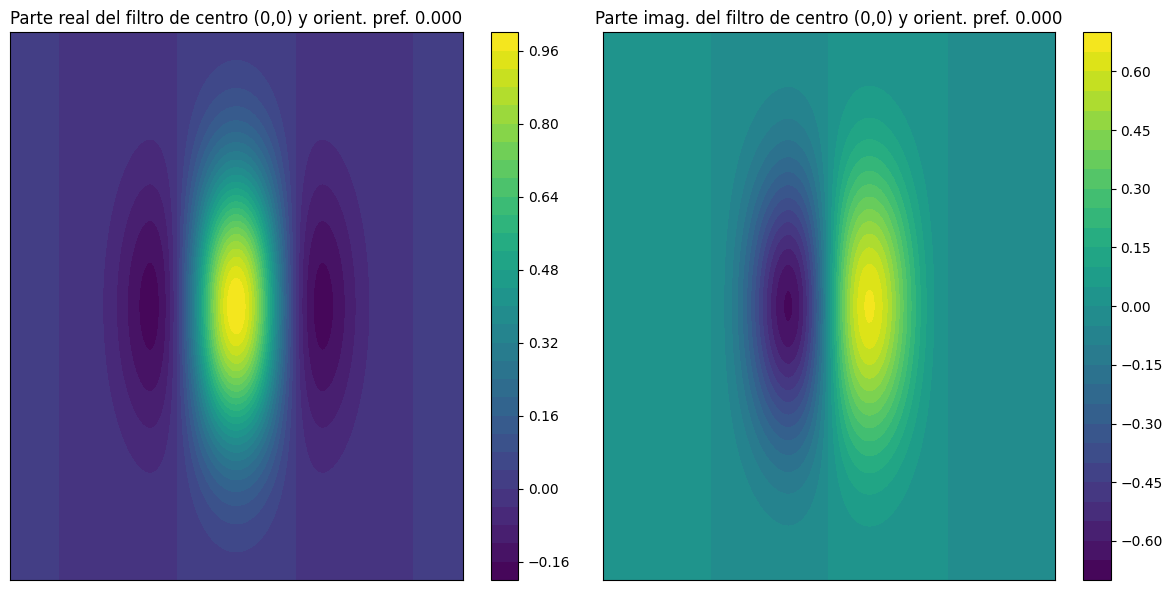

In [ ]:
plot_gabor(0,0,0,False)

Veamos ahora el filtro centrado en el (1,1) y girado $\pi/4$

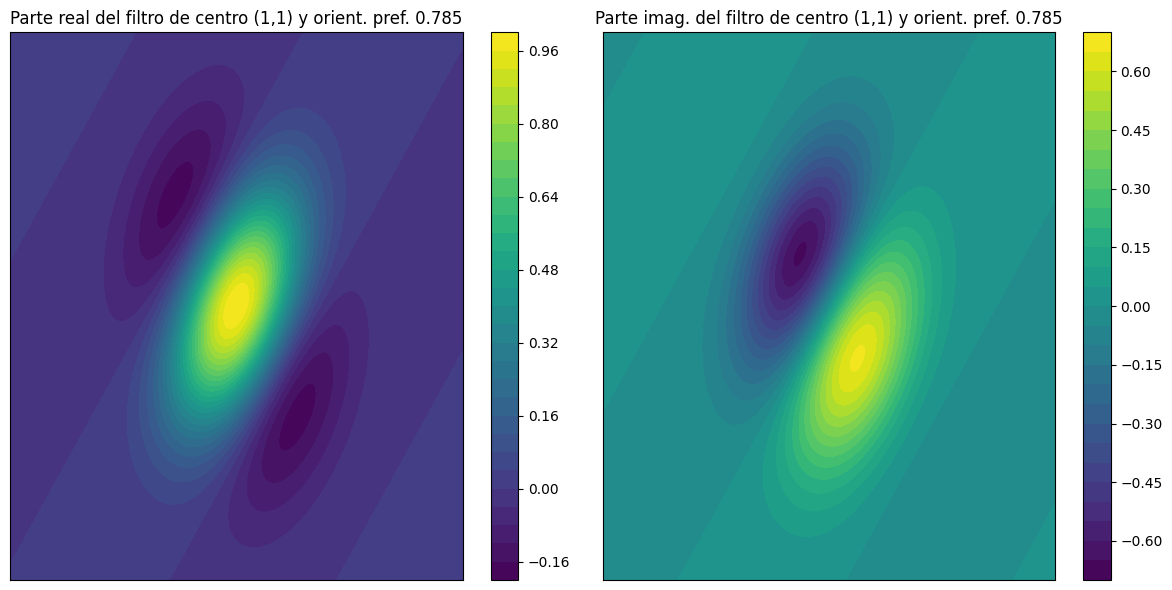

In [ ]:
plot_gabor(1,1,np.pi/4)

## **Modelado Computacional**

La siguiente celda contiene el modelo que permite obtener las orientaciones preferidas para cada píxel de la imagen. Además se incluye la implementación de un filtro de Gabor ajustando el centro $(x_0,y_0)$ y la orientación $\theta$.

In [ ]:
class GCell:
    def __init__(self):
        self.recprof = lambda posiciones : np.exp(-((posiciones[:,:,0])**2 + (posiciones[:,:,1])**2)) * np.exp(2j*(posiciones[:,:,1]))

def AccionInv(posiciones,x,y,phi):
    #devuelve el punto con la rotacion inversa y desplazado -
    return np.matmul((posiciones - np.array([x,y])), np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]]))

def O(x,y,phi,imagen,gcell,posiciones):
    return np.sum(imagen * (gcell.recprof(posiciones)))

def searchPhiP(x,y,imagen,gcell):
    posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))

    espacioBusqueda = np.linspace(0,np.pi,60) #las fibras son S1 pero modulo pi

    return (espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))],x,y)

def allPhiP(imagen,gcell,startFromSomewhere=False):
    #startFromSomewhere: True retomo cálculo desde el json resultados/preferredOrientation_it, False desde cero
    arr = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])
    if not startFromSomewhere:
        prefdOr = {(x,y):None for x,y in arr}
    else:
        #retomamos el cálculo desde otro punto
        with open('resultados/preferredOrientation_it.json') as file:
            aux = json.load(file)
        mydict2 = {eval(k):v for k,v in aux.items()}
        prefdOr = mydict2 #este diccionario contiene Nones, voy a eliminar de arr aquellos cálculos que ya he hecho
        arr = np.array([t for t in arr if prefdOr[(t[0],t[1])] == None])

    total = arr.shape[0]
    update = 0
    division5porciento = int(total * 0.05) #saco paquetes de 5% del total

    print("Saving data in resultados/preferredOrientation_it.json")
    with tqdm(total=total) as progressB:
        with ThreadPoolExecutor() as executor:
            resultados = [executor.submit(lambda args : searchPhiP(imagen=imagen, gcell=gcell,**{'x':args[0], 'y':args[1]}), tup) for tup in arr]
            for future in as_completed(resultados):
                res, x, y = future.result()
                prefdOr[(x,y)] = res

                progressB.update(1)

                #voy a actualizar el guardado del cálculo cada 5% del total
                if progressB.n == total or (division5porciento != 0 and progressB.n%division5porciento == 0):
                    update+=1
                    #guardo en resultados/nombre_json
                    with open(f'resultados/preferredOrientation_it.json', 'w') as file:
                        json.dump({str(k): v for k, v in prefdOr.items()}, file, indent=4)
                    if progressB.n != total: print(f"Data update nº{update}")
                    else: print(f"Final update")

    return prefdOr

def scatterDict(datos,image,plotProyection=False):
    x = np.array([coord[0] for coord in datos.keys()])
    y = np.array([coord[1] for coord in datos.keys()])
    z = np.array(list(datos.values()))

    mycmap = 'viridis'

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(1, 2, 1)
    scatter1 = ax1.scatter(y, -x, c=z, cmap=mycmap) #invierto, si no sale al reves
    ax1.set_aspect('equal')
    ax1.set_xlabel('Eje X')
    ax1.set_ylabel('Eje Y')
    ax1.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter1, ax=ax1, label='Orientación preferida [0,pi]',fraction=0.046, pad=0.04)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if plotProyection:
        z_ = np.zeros(np.array(list(datos.values())).shape) #sirve para visualizar la proyección de los puntos
        scatter2 = ax2.scatter(x, y, z_, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    else:
        scatter2 = ax2.scatter(x, y, z, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    ax2.set_xlabel('Eje X')
    ax2.set_ylabel('Eje Y')
    ax2.set_zlabel('PhiP')
    ax2.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter2, ax=ax2, label='Altura = PhiP',fraction=0.046, pad=0.04)
    plt.tight_layout()


    plt.show()

    if not plotProyection:
        fig2 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',marker=dict(size=1,color=z, colorscale='Viridis'))])
        fig2.update_layout(scene=dict(
                            xaxis_title='X Label',
                            yaxis_title='Y Label',
                            zaxis_title='Altura preferida'))

        fig2.show()

class V1:
    def __init__(self, ruta_imagen, reducirPixeles=1, gaussianBlurr=False, gaussianKernel = 3):
        image = Image.open(ruta_imagen)
        pixel_size = reducirPixeles #reduzco complejidad
        ancho, alto = image.size
        nuevo_ancho = ancho // pixel_size
        nuevo_alto = alto // pixel_size
        imagen_pixelada = image.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
        image = imagen_pixelada.convert('L')
        imagen = np.array(image)
        if gaussianBlurr:
            gaussian_kernel = gaussianKernel
            imagen = cv2.GaussianBlur(imagen.copy(), (gaussian_kernel,gaussian_kernel), 0) #convoluciono por una gaussiana
        self.ruta_imagen = ruta_imagen
        self.imagen = imagen
        self.prefdOr = None

    def loadCalcs(self):
      with open("./safeCalcs/"+self.ruta_imagen.split(".")[0].split("/")[1]+".json") as file:
        aux = json.load(file)
      self.prefdOr = {eval(k):v for k,v in aux.items()}
      print("Cálculos cargados para la imagen {}".format(self.ruta_imagen))

    def process(self, savedCalcs=False, loadCalcs=False):
        # si ya hay cálculos guardados en el directorio, retomar por donde se acabó con savedCalcs=True
        if loadCalcs :
          self.loadCalcs()
        else:
          ganglionarCell = GCell()
          self.prefdOr =  allPhiP(self.imagen, ganglionarCell, savedCalcs)

    def saveCalcs(self, rutaSave=None):
        if self.prefdOr == None :
          print("No hay datos guardados en el diccionario.")
        elif rutaSave==None or (rutaSave in ['',' ']):
          print("Introduce un nombre para guardar el json.")
        else:
          if os.path.exists("./resultados"):
            with open("./resultados"+rutaSave+".json", 'w') as file:
              json.dump({str(k): v for k, v in self.prefdOr.items()}, file, indent=4)
          else:
            os.makedirs("./resultados")
            with open("./resultados"+rutaSave+".json", 'w') as file:
              json.dump({str(k): v for k, v in self.prefdOr.items()}, file, indent=4)

    def show(self, flatten=False):
        scatterDict(self.prefdOr, self.imagen, flatten)

    def showFibration(self, addLines=False, addPoints=True, addInitial=True, addGaussianBlurr=False):
         #Hago la convolución con una gaussiana
        gaussifyed_image = cv2.GaussianBlur(self.imagen.copy(), (3,3), 2)

        # obtengo los puntos de la curva (bordes), en forma de indexado de puntos pixeles (x,y)
        if addGaussianBlurr :
            bordes = cv2.Canny(gaussifyed_image.copy(), 0, 10)
        else:
            bordes = cv2.Canny(self.imagen.copy(), 0, 10)

        #extraemos contornos (nos devuelve un orden apropiado para hacer el plot go)
        (contornos, _) = cv2.findContours(bordes.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #conts = cv2.drawContours(self.imagen.copy(),contornos,-1,(0,0,255), 2)

        fig = go.Figure(layout=dict(width=1000, height=1000))

        if addLines:
            for contorno in contornos:
                #cuando hacemos el findcontours puede haber varias componentes conexas
                contorno = contorno.reshape((contorno.shape[0],2))
                xe = contorno[:,1] #findcontours invierte las componentes
                ye = contorno[:,0]
                z = np.array([self.prefdOr[(i[1],i[0])] for i in contorno]) #invierte las componentes
                fig.add_trace(go.Scatter3d(x=xe, y=ye, z=z, mode='lines+markers', marker=dict(size=1,color=z,colorscale='Viridis'), line=dict(color=z,colorscale='Viridis', width=2)))


        #creo una matriz con todos los índices apuntando a pixeles de la self.imagen de los bordes
        indices_bordes = np.argwhere(np.ones_like(bordes)).reshape((*np.ones_like(bordes).shape,2))

        #tengo que hacer reshape a lo anterior para que sea una de tamaño 100,2
        indices_bordes = indices_bordes.reshape(-1, *np.argwhere(np.ones_like(self.imagen)).reshape((*np.ones_like(self.imagen).shape,2)).shape[2:])

        # ya tengo los índices de los puntos del borde de la imagen, ahora busco en mi diccionario self.prefdOr, y los subo al fibrado (creando otro diccionario)
        dic_bordes_fibrado = {(k[0],k[1]): self.prefdOr[(k[0],k[1])] if (bordes[(k[0],k[1])] == 255) else 0 for k in indices_bordes}

        #saco los puntos(indices) que pertenecen a un borde
        puntos_bordes_altura = {k:v for k,v in dic_bordes_fibrado.items() if dic_bordes_fibrado[k] != 0} #me quedo con los items quetengan altura
        puntos_cv = np.array([i for i in dic_bordes_fibrado.keys() if bordes[i[0],i[1]]!=0]) #puntos reales del borde 2D


        #saco los puntos 2D y la altura z
        puntos_bordes_2D = np.array(list(puntos_bordes_altura.keys()))
        z = np.array(list(puntos_bordes_altura.values()))

        #separo los x e y de puntos_bordes_2D
        x,y = puntos_bordes_2D[:,0], puntos_bordes_2D[:,1]

        if addPoints:
            fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=2,color=z,colorscale='Viridis'), name='Datos originales'))

        if addInitial:
            fig.add_trace(go.Scatter3d(x=puntos_cv[:,0].ravel(), y=puntos_cv[:,1].ravel(), z=np.zeros(puntos_cv[:,1].ravel().size), mode='markers', marker=dict(size=1,color='red'), name='Original'))

        fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Altura Preferida'))
        fig.show()

<br><br><br>
Una vez definido el código, en el siguiente formulario se pueden ajustar los parámetros para procesar la imagen. Es necesario ejecutar la celda del formulario una vez.

<br><br>

<p style="font-size: 2em;">Parámetro</p> | <p style="font-size: 2em;">Descripción</p>
--- | ---
<p style="font-size: 2em;">**`imageToLoad`**</p>    | <p style="font-size: 2em;">La imagen a cargar para realizar los cálculos. Puede ser seleccionada de una lista de opciones. <br> <br> Es posible subir a Colab una imagen propia, será necesario guardar la imagen en ./img y ajustar <br> apropiadamente con el nombre de la imagen este parámetro. </p>    
<p style="font-size: 2em;">**`pixelReduction`** </p>   | <p style="font-size: 2em;">La reducción de píxeles a aplicar a la imagen cargada. Se controla mediante un control deslizante. <br><br> Reduce la complejidad de los cálculos pixelando la imagen.  </p>    
<p style="font-size: 2em;">**`addGaussianBlurr`** </p>   | <p style="font-size: 2em;">Un indicador booleano que determina si se debe aplicar un desenfoque gaussiano a la imagen.     </p>          
<p style="font-size: 2em;">**`gaussianKernel`**  </p>  | <p style="font-size: 2em;">El tamaño del kernel gaussiano a aplicar si `addGaussianBlurr` es verdadero. </p>
<p style="font-size: 2em;">**`loadCalcs`**  </p>  | <p style="font-size: 2em;">Un indicador booleano que determina si se deben cargar los cálculos previamente descargados. <br><br> Ajustándolo a `True` se cargarán los cálculos ya hechos guardados en `./safeCalcs` para la imagen elegida por `imageToLoad`<br><br> Todos los cálculos preguardados han sido obtenidos usando las imágenes sin desenfoque gaussiano y sin reducción <br>(`addGaussianBlurr=False` y `pixelReduction=1`) </p>
<p style="font-size: 2em;">**`resumeCalcs`**  </p>  | <p style="font-size: 2em;">Un indicador booleano que determina si se deben reanudar los cálculos guardados si están disponibles. <br><br> Útil cuando, durante el cálculo en una imagen desde 0 (con `loadCalcs=False`), se interrumpen los cálculos por cualquier <br> motivo y queremos retomar los cálculos desde el punto que paró el algoritmo.   </p>


<br><br><br>

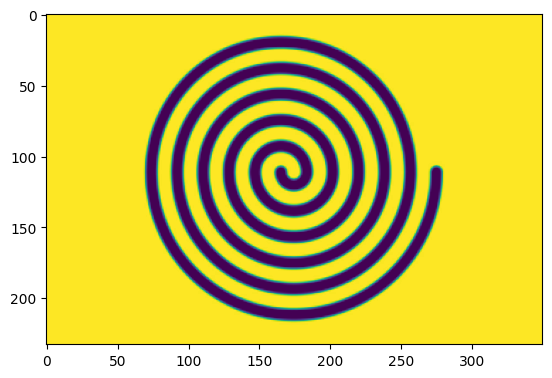

In [ ]:
# @title Parámetros para el modelo { run: "auto", form-width: "50%", display-mode: "form" }
!ls ./img > ./img/aux
imagenes = []
with open('./img/aux') as file:
    for image in file.readlines()[1:]:
        #descarto el nombre del archivo y limpio el nombre de /n
        imagenes.append(image.replace('\n',''))
    file.close()
#print(imagenes) #descomentar para detectar nuevas imagenes en img para el formulario
!rm -f ./img/aux

#tengo que copiar manualmente el contenido de imagenes en el param abajo
imageToLoad = "espiral.png" # @param ['circle.png', 'cohete.png', 'einstmary.jpg', 'espiral.png', 'kanizsa.jpg', 'linea.png', 'perro.jpg', 'semicircle.png', 'semiestere.jpg', 'toro.png']
pixelReduction = 1 # @param {type:"slider", min:1, max:30, step:1}
addGaussianBlurr = False # @param {type:"boolean"}
gaussianKernel = 3 # @param {type:"slider", min:3, max:25, step:2}
loadCalcs = True # @param {type:"boolean"}
resumeCalcs = False # @param {type:"boolean"}

imagenAux = Image.open(f'img/{imageToLoad}')
pixel_size = pixelReduction #reduzco complejidad
ancho, alto = imagenAux.size
nuevo_ancho = ancho // pixel_size
nuevo_alto = alto // pixel_size
imagenAux = imagenAux.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
imagenAux = np.array(imagenAux)
if addGaussianBlurr:
    imagenAux = cv2.GaussianBlur(imagenAux.copy(), (gaussianKernel,gaussianKernel), 0)

_ = plt.imshow(imagenAux)

Una vez definidos los parámetros anteriores, definimos una instancia de la clase V1, que será la encargada de procesar la imagen.


Ejecutamos el modelo, que usará los parámetros del formulario anterior.

In [ ]:
myV1 = V1(f'img/{imageToLoad}',reducirPixeles = pixelReduction, gaussianBlurr = addGaussianBlurr, gaussianKernel = gaussianKernel)
myV1.process(loadCalcs=loadCalcs, savedCalcs=resumeCalcs)

Cálculos cargados para la imagen img/espiral.png


Podemos visualizar las orientaciones preferidas calculadas para cada punto de la imagen. Ajustamos un parámetro.

<br>

<p style="font-size: 2em;">Parámetro </p>| <p style="font-size: 2em;">Descripción</p>
--- | ---
<p style="font-size: 2em;">**`aplanarFibrado`** </p>| <p style="font-size: 2em;">Si `True` se muestra el fibrado aplanado en el eje $z=0$</p>

<br>


Es necesario ejecutar la celda del formulario una vez.

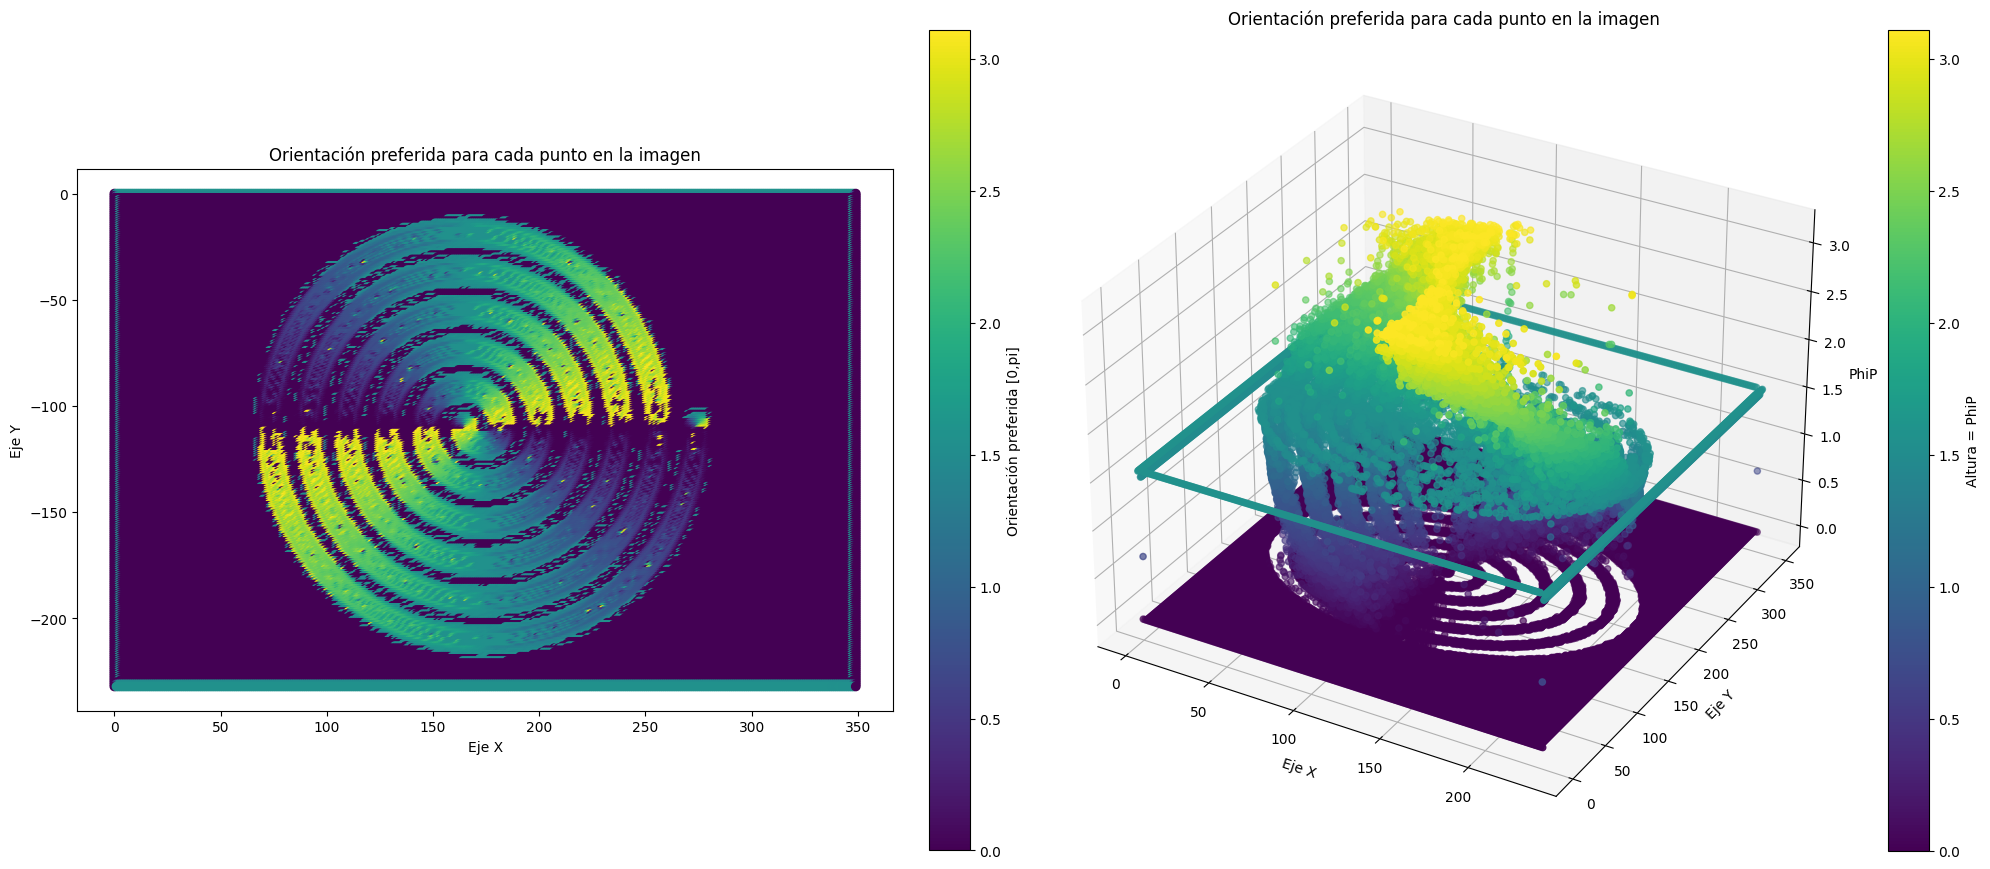

In [ ]:
# @title Primera visualización de las orientaciones preferidas { run: "auto" }
aplanarFibrado = False # @param {type:"boolean"}

myV1.show(flatten = aplanarFibrado) #add flatten si se quiere

## **Visualización del fibrado**

Veamos de manera más clara el fibrado.

<br>

<p style="font-size: 2em;">Parámetro</p> | <p style="font-size: 2em;">Descripción</p>
--- | ---
<p style="font-size: 2em;">**`addLines`**</p>    | <p style="font-size: 2em;">Un indicador booleano que determina si se deben añadir las elevaciones Legendrianas del contorno en el fibrado. </p>    
<p style="font-size: 2em;">**`addPoints`** </p>   | <p style="font-size: 2em;">Un indicador booleano que determina si se deben añadir los que indican las orientaciones preferidas en el fibrado. </p>    
<p style="font-size: 2em;">**`addInitial`** </p>   | <p style="font-size: 2em;">Un indicador booleano que determina si se deben añadir los contornos originales, en el plano $z=0$. </p>          
<p style="font-size: 2em;">**`addGaussianBlurr`**  </p>  | <p style="font-size: 2em;">Un indicador booleano que determina si se debe aplicar un desenfoque gaussiano a los contornos de la imagen. </p>


<br><br>

In [ ]:
# @title Parámetros para la visualización del fibrado { run: "auto", vertical-output: true }
addLines = True # @param {type:"boolean"}
addPoints = True # @param {type:"boolean"}
addInitial = True # @param {type:"boolean"}
addGaussianBlurr = True # @param {type:"boolean"}
#addLines=False, addPoints=True, addInitial=True, addGaussianBlurr=False

myV1.showFibration(addLines, addPoints, addInitial, addGaussianBlurr)